### Problem Statement : Detect whether a human is malaria infected using the cell images.

### Dataset

Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/ 

The dataset contains 27,558 images and 2 folders
- Infected
- Uninfected

### Approach 
Here we are trying to experiment the study using a custom but simple CNN architecture and by using transfer learning approach.

We will use VGG19 since it gives better accuracy than other models. VGG 19 is a 1000 class classifier. 
Here the problem statement is of 2 class classifier.

In [1]:
import tensorflow as tf
print (tf.__version__)

2.7.0


In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [23]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

# Open any image using paint and check for pixels. Change it to 224 X 224. Image will be enlarged.
# why resize? VGG 19 model has been designed such that i/p size is 224 X 224. 

train_path = 'Dataset/Train'
valid_path = 'Dataset/Test'

# we will be giving this path to image data generator

In [4]:
# Import the Vgg 19 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg19 = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# +[3] means add the no of channels ie 3 indicates RGB channel. 1 for black&white images. So resultant size is 224 X 224 X 3
#Last fully connected layer will get removed when we declare include_top = False

In [5]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
# don't train existing weights
# we should not train the VGG 16 layers cos they are already trained and fixed.
for layer in vgg19.layers:
    layer.trainable = False

In [24]:
# useful for getting number of output classes
folders = glob('Dataset/Train/*')

In [25]:
print(folders)
print(len(folders))

['Dataset/Train\\Parasite', 'Dataset/Train\\Uninfected']
2


In [8]:
print (vgg19.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")


In [9]:
# our layers - you can add more if you want
# we will flatten the outputs of vgg19 untill the last max pooling layer.
x = Flatten()(vgg19.output)

In [10]:
# Dense layer will be added after flattening

prediction = Dense(len(folders), activation='softmax')(x)

# here we are having two nodes at o/p, hence used softmax. 
# If there was only 1 node, ie binary classification, we can use sigmoid.

# create a model object
model = Model(inputs=vgg19.input, outputs=prediction)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
from tensorflow.keras.layers import MaxPooling2D

In [26]:
### Create Model from scratch using CNN
cnn_model=Sequential()
cnn_model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(224,224,3)))
cnn_model.add(MaxPooling2D(pool_size=2))
cnn_model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation ="relu"))
cnn_model.add(MaxPooling2D(pool_size=2))
cnn_model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
cnn_model.add(MaxPooling2D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(500,activation="relu"))
cnn_model.add(Dense(2,activation="softmax"))
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      208       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      2080      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 64)        8256      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 64)      

In [27]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [29]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [30]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('Dataset/Train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 416 images belonging to 2 classes.


In [53]:
training_set

In [31]:
test_set = test_datagen.flow_from_directory('Dataset/Test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 134 images belonging to 2 classes.


In [18]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-18-2d02736eff38>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/20
13/13 [==============================] - 72s 5s/step - loss: 1.5018 - accuracy: 0.5144 - val_loss: 1.6092 - val_accuracy: 0.3358
Epoch 2/20
13/13 [==============================] - 69s 5s/step - loss: 0.6684 - accuracy: 0.6659 - val_loss: 0.5060 - val_accuracy: 0.7015
Epoch 3/20
13/13 [==============================] - 69s 5s/step - loss: 0.4406 - accuracy: 0.7957 - val_loss: 0.4592 - val_accuracy: 0.7612
Epoch 4/20
13/13 [==============================] - 69s 5s/step - loss: 0.3582 - accuracy: 0.8486 - val_loss: 0.4613 - val_accuracy: 0.7836
Epoch 5/20
13/13 [==============================] - 71s 6s/step - loss: 0.3081 - accuracy: 0.8774 - val_loss: 0.4549 - val_accuracy: 0.7761
Epoch 6/20
13/13 [==============================] - 70s 5s/step - loss: 0.3010 - accuracy: 0.8942 - val_loss: 0.5220 - val_accuracy: 0.7090
Epoch 7/20
13/13 [==============================] - 70s 5s/step - loss: 0.2636 - accuracy: 0.9183 - val_loss: 0.3602 - val_accuracy: 0.8657
Epoch 8/20
13/13 [==

In [28]:
# tell the model what cost and optimization method to use
cnn_model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [32]:
# fit the model
cnn_r = cnn_model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-32-78c8e771bef9>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn_r = cnn_model.fit_generator(


Epoch 1/20
13/13 [==============================] - 13s 895ms/step - loss: 2.4992 - accuracy: 0.5000 - val_loss: 1.0180 - val_accuracy: 0.3209
Epoch 2/20
13/13 [==============================] - 12s 898ms/step - loss: 0.6968 - accuracy: 0.5457 - val_loss: 0.6646 - val_accuracy: 0.6791
Epoch 3/20
13/13 [==============================] - 12s 874ms/step - loss: 0.6769 - accuracy: 0.5889 - val_loss: 0.6425 - val_accuracy: 0.6791
Epoch 4/20
13/13 [==============================] - 11s 851ms/step - loss: 0.6433 - accuracy: 0.6274 - val_loss: 0.7935 - val_accuracy: 0.4030
Epoch 5/20
13/13 [==============================] - 12s 882ms/step - loss: 0.5894 - accuracy: 0.6731 - val_loss: 0.7122 - val_accuracy: 0.6642
Epoch 6/20
13/13 [==============================] - 11s 810ms/step - loss: 0.6581 - accuracy: 0.6010 - val_loss: 0.8098 - val_accuracy: 0.3881
Epoch 7/20
13/13 [==============================] - 11s 819ms/step - loss: 0.6086 - accuracy: 0.6659 - val_loss: 0.7248 - val_accuracy: 0.4552

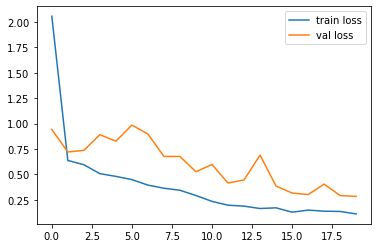

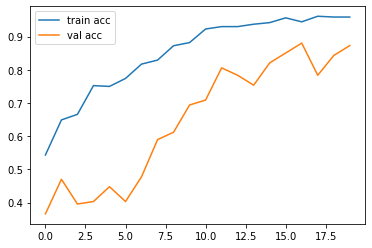

<Figure size 432x288 with 0 Axes>

In [21]:
# plot loss and accuracy of VGG19 model

# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

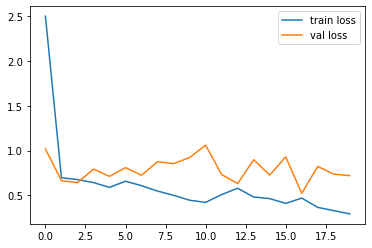

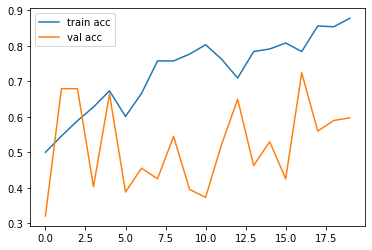

<Figure size 432x288 with 0 Axes>

In [33]:
# Custom CNN model
# plot the loss
plt.plot(cnn_r.history['loss'], label='train loss')
plt.plot(cnn_r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(cnn_r.history['accuracy'], label='train acc')
plt.plot(cnn_r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [58]:
# save it as a h5 file

from tensorflow.keras.models import load_model

model.save('model_vgg19.h5')

In [59]:
y_pred = model.predict(test_set)

In [60]:
y_pred

array([[0.1911175 , 0.8088825 ],
       [0.09748951, 0.9025105 ],
       [0.01921241, 0.98078763],
       [0.30325744, 0.6967426 ],
       [0.9749078 , 0.02509223],
       [0.03497441, 0.96502554],
       [0.21231782, 0.7876822 ],
       [0.47197685, 0.5280232 ],
       [0.05789036, 0.9421096 ],
       [0.61181813, 0.3881819 ],
       [0.22986393, 0.770136  ],
       [0.87033284, 0.12966718],
       [0.62784207, 0.37215793],
       [0.8306896 , 0.16931036],
       [0.13970636, 0.8602936 ],
       [0.1794278 , 0.8205722 ],
       [0.85831845, 0.14168155],
       [0.8680497 , 0.13195029],
       [0.92704964, 0.07295041],
       [0.9565604 , 0.04343962],
       [0.9618586 , 0.03814146],
       [0.88262   , 0.11738008],
       [0.6478759 , 0.35212412],
       [0.17137992, 0.8286201 ],
       [0.54584557, 0.45415446],
       [0.65021455, 0.34978548],
       [0.49689576, 0.50310427],
       [0.6065613 , 0.39343873],
       [0.61745805, 0.38254192],
       [0.7385308 , 0.2614692 ],
       [0.

### Inference
Since we have used dense layer as 2 nodes, we will get two values. Sum of both should be 1.
In the training dataset 0 means parasite, 1 means uninfected. So whenever we have higher value at first place indicates that will be a parastic image ortherwise uninfected.


In [61]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

# in the y_pred, whicever will be the maximum value ,return the argument (index) of that.


y_pred

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0], dtype=int64)

In [68]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [78]:
loaded_model = load_model('model_vgg19.h5')

In [79]:
test_img1 = image.load_img('Dataset/Test/Uninfected/2.png', target_size=(224,224))
test_img2 = image.load_img('Dataset/Test/Parasite/C39P4thinF_original_IMG_20150622_110115_cell_118.png', target_size=(224,224))

In [87]:
x= image.img_to_array(test_img2)
x

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [81]:
x.shape

(224, 224, 3)

In [88]:
x=x/255   # Since we did this for y_test

In [89]:
x = np.expand_dims(x,axis=0)  # In CNN this much no of dimesions is required wrt images. 

In [90]:
img_data= preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [91]:
loaded_model.predict(img_data)

array([[1., 0.]], dtype=float32)

In [92]:
a= np.argmax(loaded_model.predict(img_data), axis=1)

if (a==1):
    print ("Uninfected")
else: 
    print ("Infected")

Infected
